In [1]:
# ViT : Vision Transformer
#   트랜스포머 모델을 이미지 분석에 적용한 모델
#   Conv layer 대신 이미지를 패치 단위로 나누어 입력

In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.datasets import cifar10

from vit_keras import vit, utils
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import gc

c:\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
(tr_data, tr_label), (ts_data, ts_label) = cifar10.load_data()

tr_label = to_categorical(tr_label)
ts_label = to_categorical(ts_label)
tr_data = (tr_data/255.).astype('float32')
ts_data = (ts_data/255.).astype('float32')

x_tr, x_val, y_tr, y_val = train_test_split(tr_data, tr_label, random_state=seed, shuffle=True)

In [5]:
x_tr = x_tr[::200]
x_val = x_val[::200]
y_tr = y_tr[::200]
y_val = y_val[::200]

In [6]:
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((188, 32, 32, 3), (188, 10), (63, 32, 32, 3), (63, 10))

In [7]:
batch_size = 1
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(x_tr, y_tr, batch_size=batch_size)


In [10]:
# ViT 모델

# 1.전이학습
input_shape = (32, 32, 3)   # cifar10 이미지사이즈
image_size = 256   # resize
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    # resize image
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs)
    # vit 모델
    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True, include_top=False, pretrained_top=False)    
    # 추론모드로 설정(전이학습)
    base_model.trainable = False
    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tfa.activations.gelu)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final

model = build_model()
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_2 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                24608     
                                                           

In [12]:
model.fit(train_generator, epochs=2, validation_data=(x_val, y_val),)
gc.collect()

Epoch 1/2
188/188 [==============================] - 40s 140ms/step - loss: 2.3122 - accuracy: 0.0479 - val_loss: 9.7819 - val_accuracy: 0.0952
Epoch 2/2
188/188 [==============================] - 24s 127ms/step - loss: 2.3109 - accuracy: 0.0798 - val_loss: 59.6174 - val_accuracy: 0.1111


724

In [ ]:
# epochs 과 데이터 늘려서 더 해봐야 함


In [13]:
#2. fine tuning
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
                            # patience: 횟수, loss줄어들지 않으면 끝내라
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
#훈련모드로 변경
for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_2 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                24608     
                                                           

In [14]:
tf.keras.backend.clear_session()

gc.collect()

171

In [15]:
history = model.fit(train_generator,
                    epochs=2,
                    validation_data=(x_val, y_val),
                    callbacks=[plateau, earlystopping])

Epoch 1/2
188/188 [==============================] - 66s 274ms/step - loss: 2.3007 - accuracy: 0.0957 - val_loss: 321.7559 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/2
188/188 [==============================] - ETA: 0s - loss: 2.3006 - accuracy: 0.1117
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
188/188 [==============================] - 49s 260ms/step - loss: 2.3006 - accuracy: 0.1117 - val_loss: 937.8362 - val_accuracy: 0.1111 - lr: 0.0010


In [17]:
accuracy_score(np.argmax(ts_label[::150], axis=1), np.argmax(model.predict(ts_data[::150]), axis=1))

3/3 [==============================] - 6s 951ms/step


0.1044776119402985

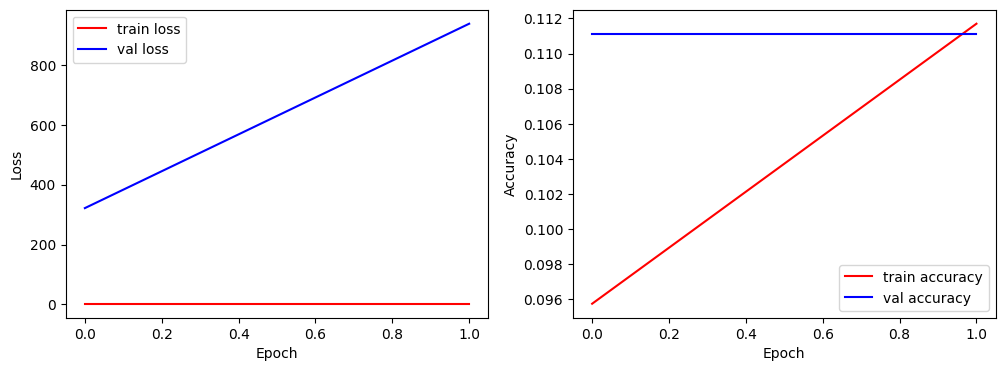

In [18]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

